##### Anders - Function to load data

In [1]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from pathlib import Path

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from pathlib import Path

class LIDC_IDRI(torch.utils.data.Dataset):
    def __init__(self, transform, mode, legions, data_path='LIDC_crops/LIDC_DLCV_version'):
        'Initialization'
        self.transform = transform
        data_path += "/" + mode
        print(data_path)
        self.image_paths = [data_path + "/images/" + path.name for path in Path(data_path + "/images").rglob('*')]
        
        all_target_paths = [data_path + "/lesions/" + path.name for path in Path(data_path + "/lesions").rglob('*')]
        self.target_paths = []
        for legion in legions:
            legion_path = [path for path in all_target_paths if path.endswith(f"l{legion}.png")]
            self.target_paths.extend(legion_path)
        
        im = Image.open(self.image_paths[0])
        X = self.transform(im)
        self.dim = X.shape[1]
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)
    
    def get_input_im(self, idx):
        return Image.open(self.image_paths[idx])
    
    def get_legion_im(self, idx):
        return Image.open(self.target_paths[idx])
    
    def get_x_tensor(self, idx):
        input_im = self.get_input_im(idx)
        return self.transform(input_im)
    
    def get_y_tensor(self, idx):
        target_im = self.get_legion_im(idx)
        return self.transform(target_im)
    
    def __getitem__(self, idx):
        'Generates one sample of data'
        X = self.get_x_tensor(idx)
        y = self.get_y_tensor(idx)
        return X, y
    
    def im_show(self, idx):
        'Shows one input image'
        input_im = Image.open(self.image_paths[idx])
        plt.imshow(input_im)
        
    def legion_show(self, idx):
        target_im = Image.open(self.target_paths[idx])
        plt.imshow(target_im)

In [31]:
transform = transforms.Compose([transforms.ToTensor()])
data_validation = LIDC_IDRI(transform, mode='val', legions=[0])

LIDC_crops/LIDC_DLCV_version/val


In [30]:
data_test = LIDC_IDRI(transform, mode='test', legions=[0])

LIDC_crops/LIDC_DLCV_version/test


In [33]:
data_train = LIDC_IDRI(transform, mode='train', legions=[0])

LIDC_crops/LIDC_DLCV_version/train


In [39]:
data_train.dim, data_test.dim, data_validation.dim

(128, 128, 128)

In [119]:
X,y = data_train.__getitem__(0)

In [121]:
y.shape

torch.Size([1, 128, 128])

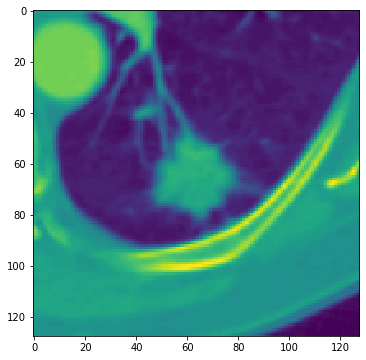

In [99]:
data_train.im_show(6)

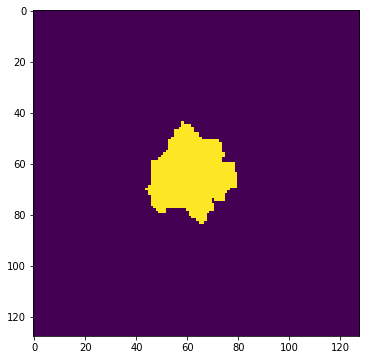

In [105]:
im1 = data_test.get_input_im(6)
data_train.legion_show(6)

In [9]:
y_test = data_train.get_y_tensor(12)
y_pred = data_train.get_y_tensor(14)

In [51]:
X = np.array(X, np.float32)
Y = np.array(y, np.float32)

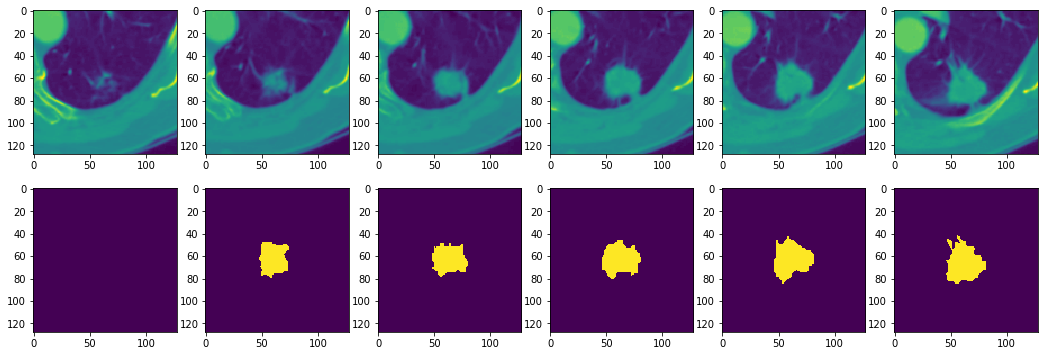

In [73]:
from IPython.display import clear_output
plt.rcParams['figure.figsize'] = [18,6]

for i in range(6):
    plt.subplot(2,6,i+1)
    data_train.im_show(i)
    
    plt.subplot(2,6,i+7)
    data_train.get_input_im(i)
    data_train.legion_show(i)
plt.show();

In [113]:
data_train.dim

128

In [160]:
batch_size = 32
transform = transforms.Compose([transforms.ToTensor()])

data_train = LIDC_IDRI(transform, mode='train', legions=[0])
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=0)
data_val = LIDC_IDRI(transform, mode='val', legions=[0])
val_loader = DataLoader(data_val, batch_size=batch_size, shuffle=True, num_workers=0)
data_test = LIDC_IDRI(transform, mode='test', legions=[0])
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=True, num_workers=0)

#num_workers = 2

LIDC_crops/LIDC_DLCV_version/train
LIDC_crops/LIDC_DLCV_version/val
LIDC_crops/LIDC_DLCV_version/test


### AB -  Loss functions
y_test: the true results 

y_pred: the predicted results from the model

h: hight of image

w: width of image 

In [10]:
y_test = data_train.get_y_tensor(12)
y_pred = data_train.get_y_tensor(14)
y_test_np = y_test.numpy()
y_pred_np = y_pred.numpy()

### Intersection over Union = $\frac{\text{Area of overlap}}{\text{Area of union}}$
### Dice = $2\cdot\frac{\text{Area of overlap}}{\text{Area of union}}$

In [11]:
#test = 'IoU' or 'Dice'
def Loss(y_test,y_pred, test):
    
    h = y_pred.shape[1]-1
    w = y_test.shape[1]-1
         
    
    intersection = np.sum(np.abs(y_pred*y_test))
    union = np.sum(np.abs(y_test))+np.sum(np.abs(y_pred)) - intersection
    IoU = intersection/union
    Dice = 2*intersection/(union+intersection)
    
    if test == 'IoU':
        return IoU
    if test == 'Dice':
        return Dice

### Accuracy = $\frac{\text{correctly classified pixels}}{\text{pixels in total}}$

In [12]:
def Accuracy(y_test, y_pred):
    
    #h = y_pred.shape[1]     #Height
    #w = y_test.shape[1]     #Width

    h = 128
    w = 128
    
    pixel_total = (h)*(w)
    correct = 0
    
    #Looping over each pixel in the true and the predicted image
    for i in range(y_test.shape[1]-1):
        for j in range(y_test.shape[2]-1):
            if (y_test[0,i,j] == y_pred[0,i,j]):
                correct += 1

    Accuracy = correct/pixel_total*100
    
    return Accuracy

### Sensitivity = $\frac{\text{True Positive}}{\text{True Positive+False Negative}}$

### Specificity = $\frac{\text{True Negative}}{\text{True Negative+False Positive}}$

In [13]:
#test = 'Sensitivity' or 'Specificity'
def SenSpe(y_test, y_pred, test):
        
    TP = 0
    FN = 0
    TN = 0
    FP = 0    
    
    if test == 'Sensitivity':
        for i in range(y_test.shape[1]-1):
            for j in range(y_test.shape[2]-1):

                if y_test[0,i,j] == y_pred[0,i,j] and y_test[0,i,j]==1 and y_pred[0,i,j]==1:
                    TP += 1
                if y_test[0,i,j] != y_pred[0,i,j] and y_test[0,i,j]==1 and y_pred[0,i,j]==0:
                    FN += 1
                
        Sensitivity = TP/(TP+FN)
    
    if test == 'Specificity':
        for i in range(y_test_np.shape[1]-1):
            for j in range(y_test_np.shape[2]-1):

                if y_test[0,i,j] == y_pred[0,i,j] and y_test[0,i,j]==0 and y_pred[0,i,j]==0:
                    TN += 1

                if y_test[0,i,j] != y_pred[0,i,j] and y_test[0,i,j]==0 and y_pred[0,i,j]==1:
                    FP += 1
                
        Specificity = TN/(TN+FP)
    
                
    if test == 'Sensitivity':
        return Sensitivity
    if test == 'Specificity':
        return Specificity 
    

### RESULTS

In [15]:
Loss(y_test_np,y_pred_np, 'IoU')

0.49832776

In [16]:
Loss(y_test_np,y_pred_np, 'Dice')

0.6651785714285714

In [17]:
Accuracy(y_test_np, y_pred_np)

97.528076171875

In [18]:
SenSpe(y_test_np, y_pred_np, 'Sensitivity')

0.9085365853658537

In [19]:
SenSpe(y_test_np, y_pred_np, 'Specificity')

0.9915440025054807

### Implementation of SegNet

In [22]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

In [169]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

#Encoder (downsampling)
        
        # 128 -> 64
        self.encoder_convolution0 = nn.Conv2d(1,64,3,padding=1)   
        self.pool0 = nn.MaxPool2d(3,2,padding=1)
        
        # 64 -> 32
        self.encoder_convolution1 = nn.Conv2d(64,64,3,padding=1)
        self.pool1 = nn.MaxPool2d(3,2,padding=1)
        
        # 32 -> 16
        self.encoder_convolution2 = nn.Conv2d(64,64,3,padding=1)
        self.pool2 = nn.MaxPool2d(3,2,padding=1)
        
        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64,64,3,padding=1)
        
#Decoder (upsampling)
        
        # 16 -> 32
        self.upsample0 = nn.Upsample(32)
        self.decoder_convolution0 = nn.Conv2d(64,64,3,padding=1)
        
        # 32 -> 64
        self.upsample1 = nn.Upsample(64)
        self.decoder_convolution1 = nn.Conv2d(64,64,3,padding=1)
        
        # 64 -> 128
        self.upsample2 = nn.Upsample(128)
        self.decoder_convolution2 = nn.Conv2d(64,1,3,padding=1) 
        
    def forward(self,x):
        #Encoder
        e0 = self.pool0(F.relu(self.encoder_convolution0(x)))
        e1 = self.pool1(F.relu(self.encoder_convolution1(e0)))
        e2 = self.pool2(F.relu(self.encoder_convolution2(e1)))
        
        #Bottleneck
        b = F.relu(self.bottleneck_conv(e2))
        
        #Decoder
        d0 = F.relu(self.decoder_convolution0(self.upsample0(b)))
        d1 = F.relu(self.decoder_convolution1(self.upsample1(d0)))
        d2 = self.decoder_convolution2(self.upsample2(d1))          #no activation of the last one
        return d2

### Defining a loss functon
Since we have binary segmentation (1 for cancer and 0 for background) we can use binary cross-entropy loss function.

In [170]:
def bce_loss(y_test, y_pred):
    return torch.mean(y_pred - y_test*y_pred + torch.log(1 + torch.exp(-y_pred)))

### Training  and prediction of the model

In [2]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print(' - loss: %f' % avg_loss)

        # show intermediate results
       # model.eval()  # testing mode
       #  Y_hat = F.sigmoid(model(X_val.to(device))).detach().cpu()
       # clear_output(wait=True)
     #   for k in range(6):
      #      plt.subplot(2, 6, k+1)
       #     plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
        #    plt.title('Real')
         #   plt.axis('off')

          #  plt.subplot(2, 6, k+7)
          #  plt.imshow(Y_hat[k, 0], cmap='gray')
          #  plt.title('Output')
          #  plt.axis('off')
       # plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
       # plt.show()

In [177]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [F.sigmoid(model(X_batch.to(device))) for X_batch, _ in data]
    return np.array(Y_pred)

In [178]:
model = SegNet().to(device)
summary(model, (1,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             640
         MaxPool2d-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,928
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]          36,928
          Upsample-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,928
         Upsample-10           [-1, 64, 64, 64]               0
           Conv2d-11           [-1, 64, 64, 64]          36,928
         Upsample-12         [-1, 64, 128, 128]               0
           Conv2d-13          [-1, 1, 128, 128]             577
Total params: 185,857
Trainable params:

In [3]:
train(model, optim.Adam(model.parameters()), bce_loss, 20, train_loader, val_loader)

NameError: name 'model' is not defined